In [181]:
import json
import random

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset,Subset

import matplotlib.pyplot as plt
import pandas as pd

from tqdm.notebook import tqdm

In [ ]:

summary = pd.read_csv('genome_data/data/data_summary.tsv', delimiter='\t')
summary_filtered = summary[summary['Assembly Accession'].str.contains('GCF')]

In [52]:
BASES_DICT = {s: i for i, s in enumerate("ACGTN")}

def oneHotEncode(sequence:str) -> torch.Tensor:
    L = len(sequence)
    tens = torch.zeros(5, L)

    for i, s in enumerate(sequence.upper()):
        base = BASES_DICT.get(s)
        tens[base,i]= 1.0
    
    return tens

In [ ]:
class DNAReadDataset(Dataset):

    ## tells class what to do when created
    def __init__(self, data_path):
        self.data = []

        with open(data_path, 'r') as f:
            for line in f:
                json_object = json.loads(line)
                self.data.append(json_object)
           
        all_species = sorted(set(d['species_id'] for d in self.data))
        self.species = {s: i for i, s in enumerate(all_species)}

    ## how many exmapels we have in a dataset once we get it
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        record = self.data[idx]
        x = oneHotEncode(record['sequence'])
        y = torch.tensor(self.species[record['species_id']])

        return x, y

    @property
    def classes(self):
        return self.species
    
dataset = DNAReadDataset(data_path='genome_data/generated_reads.jsonl')
dataloader = DataLoader(dataset,batch_size=128, shuffle=True)


In [ ]:
seq, spec = dataset[1800]
seq.shape
for seq, spec in dataset:
    break

In [89]:
# batchsize = # examples we pull each time we iterate thorugh, shuffle = each time is random pulling (only need when trainig)
dataloader = DataLoader(dataset,batch_size=128, shuffle=True)

In [90]:
for seqs, specs in dataloader:
    break

seqs.shape, specs.shape

(torch.Size([128, 5, 300]), torch.Size([128]))

In [ ]:
# since we put shuffle, and know labels were in order previously, we now has tensor of random order of labels
specs

tensor([4, 8, 5, 1, 4, 5, 1, 9, 1, 1, 7, 9, 7, 8, 9, 6, 2, 2, 0, 3, 5, 1, 1, 1,
        1, 6, 4, 3, 8, 5, 4, 3, 7, 7, 1, 6, 9, 2, 8, 4, 3, 8, 7, 1, 6, 2, 4, 6,
        0, 8, 4, 9, 1, 7, 2, 5, 7, 2, 2, 5, 4, 5, 0, 8, 7, 2, 3, 7, 5, 1, 5, 4,
        1, 4, 3, 5, 0, 6, 6, 2, 3, 2, 4, 6, 6, 4, 0, 0, 1, 1, 7, 4, 2, 8, 7, 2,
        0, 0, 1, 2, 3, 7, 3, 3, 5, 8, 6, 1, 7, 8, 7, 6, 5, 6, 6, 4, 6, 8, 4, 3,
        3, 8, 5, 8, 8, 8, 0, 9])

### Pytorch Model

In [113]:
### First try linear
class LinearClassifier(nn.Module):
    def __init__(self, seq_len=300, num_classes=10):
        super().__init__()
        # DECISION 1: Input size
        # - We have 5 channels × 300 length = 1500 features
        # - Need to flatten: (batch, 5, 300) → (batch, 1500)
        
        # DECISION 2: Hidden layer size
        # Rule of thumb: Start with sqrt(input_size × output_size)
        # √(1500 × 10) ≈ 122, round to 128 (powers of 2)
        
        # DECISION 3: Dropout rate
        # used for regularization to prevent overfitting (randomly drops out 
        # fraction of neurons in layer during each for/backward pass)
        # Start with 0.3 (30% dropout) - common default
        # Too high (>0.5) → underfitting
        # Too low (<0.1) → overfitting

        self.fc = nn.Sequential(
            nn.Linear(5 * seq_len, 128),  # 1500 → 128
            nn.ReLU(),                     # Non-linearity
            nn.Dropout(0.3),               # Regularization
            nn.Linear(128, num_classes)    # 128 → 10
        )

    def forward(self, x):
        x = x.flatten(start_dim=1)
        return self.fc(x)
        # reshape to flatten sequence dimension
        


In [114]:
model = LinearClassifier()


In [124]:
## add a batch dimension
output = model(seq.unsqueeze(0))

In [ ]:
output.shape # torch.Size([batch_size, numclas])
# will have probabilities for each class

torch.Size([1, 10])

In [ ]:
dataset = DNAReadDataset('genome_data/generated_reads.jsonl')

print(f"Total samples: {len(dataset)}")
print(f"Sequence length: {len(dataset.data[0]['sequence'])}")
print(f"Number of species: {len(dataset.classes)}")

Total samples: 20000


AttributeError: 'DNAReadDataset' object has no attribute 'data'

### Training Loop
- feed data into model recursively and then apply loss function to outputs 
- how the model learns
- does this in batches (step: one batch of data as defined in our dataloader)
- then call one epoch: a run thru all the batches  in one training dataset

- two thing to select:
    - optimizer: adam is best place to start
    - loss function: what model will optimize for


In [ ]:
def split_dataset(dataset, val_frac=0.2, seed=42):
    idxs = list(range(len(dataset)))
    random.Random(seed).shuffle(idxs)
    cut = int(len(idxs) * (1 - val_frac))
    train_idx, val_idx = idxs[:cut], idxs[cut:]
    return Subset(dataset, train_idx), Subset(dataset, val_idx)

dataset = DNAReadDataset('genome_data/generated_reads.jsonl')
train_dataset, testval_dataset = split_dataset(dataset)
test_dataset, val_dataset = split_dataset(testval_dataset, val_frac=0.5)


train_loader = DataLoader(train_dataset,batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset,batch_size=128, shuffle=False)


model = LinearClassifier()
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)
model.to(device)

# loss function 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


mps


In [ ]:
spec = spec.unsqueeze(0)
criterion(output, spec)

In [166]:
num_epochs = 30
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    #set model to train
    model.train()
    running_loss = 0.0
    for seq, spec in train_loader:
        seq, spec = seq.to(device), spec.to(device)
        optimizer.zero_grad()
        outputs = model(seq.float())
        loss = criterion(outputs, spec)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * seq.size(0)
    train_loss = running_loss/len(train_loader.dataset)
    train_losses.append(train_loss)

    # validation
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        #for seq, spec in tqdm(val_loader, desc="Validation loop"):
        for seq, spec in val_loader:
            seq, spec = seq.to(device), spec.to(device)
            outputs = model(seq.float())
            loss = criterion(outputs, spec)
            running_loss += loss.item() * seq.size(0)
    val_loss = running_loss/len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss} - Valid loss: {val_loss}") 


Epoch 1/30 - Train loss: 1.8217514944076538 - Valid loss: 1.6437017908096314
Epoch 2/30 - Train loss: 1.6159785461425782 - Valid loss: 1.6244164438247681
Epoch 3/30 - Train loss: 1.5549120206832885 - Valid loss: 1.634556167602539
Epoch 4/30 - Train loss: 1.5083340816497803 - Valid loss: 1.65204287815094
Epoch 5/30 - Train loss: 1.4584938383102417 - Valid loss: 1.684067392349243
Epoch 6/30 - Train loss: 1.4077321214675904 - Valid loss: 1.7071577157974243
Epoch 7/30 - Train loss: 1.3500809268951417 - Valid loss: 1.6966427459716797
Epoch 8/30 - Train loss: 1.2856188230514527 - Valid loss: 1.7190908870697021
Epoch 9/30 - Train loss: 1.2206499004364013 - Valid loss: 1.746372938156128
Epoch 10/30 - Train loss: 1.1534280018806458 - Valid loss: 1.7692419834136963
Epoch 11/30 - Train loss: 1.0963772521018982 - Valid loss: 1.7985595722198486
Epoch 12/30 - Train loss: 1.0384457936286926 - Valid loss: 1.8357502593994142
Epoch 13/30 - Train loss: 0.9718164796829224 - Valid loss: 1.8807460041046142


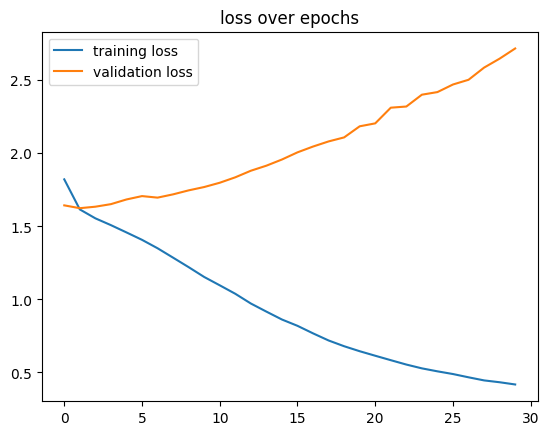

In [167]:
plt.plot(train_losses, label="training loss")
plt.plot(val_losses, label="validation loss")
plt.legend()
plt.title("loss over epochs")
plt.show()

In [168]:
### Decrease regularization
class LinearClassifier(nn.Module):
    def __init__(self, seq_len=300, num_classes=10):
        super().__init__()

        self.fc = nn.Sequential(
            nn.Linear(5 * seq_len, 128),  # 1500 → 128
            nn.ReLU(),                     # Non-linearity
            nn.Dropout(0.5),               # Regularization
            nn.Linear(128, num_classes)    # 128 → 10
        )

    def forward(self, x):
        x = x.flatten(start_dim=1)
        return self.fc(x)


In [169]:
model = LinearClassifier(seq_len=300, num_classes=10)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  

In [170]:
# Training with early stopping
num_epochs = 30
train_losses, val_losses = [], []
train_accs, val_accs = [], []

best_val_loss = float('inf')
patience = 5
patience_counter = 0

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for seq, spec in train_loader:
        seq, spec = seq.to(device), spec.to(device)
        
        optimizer.zero_grad()
        outputs = model(seq.float())
        loss = criterion(outputs, spec)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * seq.size(0)
        _, predicted = outputs.max(1)
        train_total += spec.size(0)
        train_correct += predicted.eq(spec).sum().item()
    
    train_loss = running_loss / len(train_loader.dataset)
    train_acc = 100. * train_correct / train_total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validation
    model.eval()
    running_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for seq, spec in val_loader:
            seq, spec = seq.to(device), spec.to(device)
            outputs = model(seq.float())
            loss = criterion(outputs, spec)
            
            running_loss += loss.item() * seq.size(0)
            _, predicted = outputs.max(1)
            val_total += spec.size(0)
            val_correct += predicted.eq(spec).sum().item()
    
    val_loss = running_loss / len(val_loader.dataset)
    val_acc = 100. * val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"Epoch {epoch+1:2d}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:5.2f}% | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:5.2f}%")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_linear_model.pt')
        print("  → Saved best model")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

# Load best model
model.load_state_dict(torch.load('best_linear_model.pt'))


Epoch  1/30 | Train Loss: 1.8557 Acc: 26.87% | Val Loss: 1.6561 Acc: 35.60%
  → Saved best model
Epoch  2/30 | Train Loss: 1.6551 Acc: 33.97% | Val Loss: 1.6304 Acc: 34.80%
  → Saved best model
Epoch  3/30 | Train Loss: 1.5935 Acc: 36.84% | Val Loss: 1.6331 Acc: 35.65%
Epoch  4/30 | Train Loss: 1.5515 Acc: 39.88% | Val Loss: 1.6346 Acc: 35.40%
Epoch  5/30 | Train Loss: 1.5128 Acc: 42.54% | Val Loss: 1.6472 Acc: 33.10%
Epoch  6/30 | Train Loss: 1.4728 Acc: 43.73% | Val Loss: 1.6644 Acc: 32.65%
Epoch  7/30 | Train Loss: 1.4262 Acc: 45.73% | Val Loss: 1.6683 Acc: 33.70%

Early stopping at epoch 7


<All keys matched successfully>

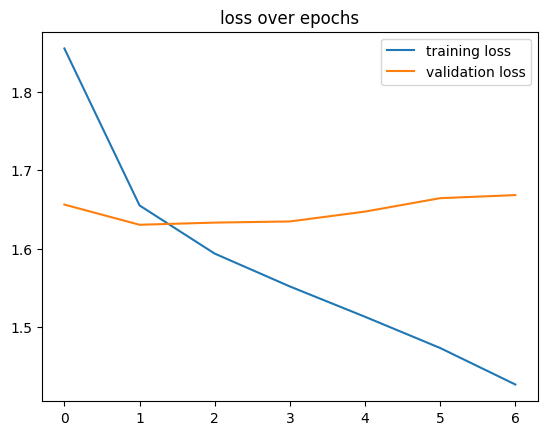

In [171]:
plt.plot(train_losses, label="training loss")
plt.plot(val_losses, label="validation loss")
plt.legend()
plt.title("loss over epochs")
plt.show()

In [ ]:
## TEST
def test_model(model, test_loader, device):
    model.eval()
    
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    
    all_preds = []
    all_labels = []
    
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for seq, spec in test_loader:
            seq, spec = seq.to(device), spec.to(device)
            
            outputs = model(seq.float())
            loss = criterion(outputs, spec)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            test_total += spec.size(0)
            test_correct += predicted.eq(spec).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(spec.cpu().numpy())
    
    test_loss /= len(test_loader)
    test_acc = 100. * test_correct / test_total
    
    print("="*60)
    print("TEST SET RESULTS")
    print("="*60)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.2f}%")
    print()
    
    return test_loss, test_acc, all_preds, all_labels


test_loss, test_acc, preds, labels = test_model(model, test_loader, device)

print(f"\nLINEAR BASELINE: {test_acc:.2f}% test accuracy")

TEST SET RESULTS
Test Loss: 1.6546
Test Accuracy: 32.35%


LINEAR BASELINE: 32.35% test accuracy


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, seq_len=300, num_classes=10):
        super().__init__()
        
        self.features = nn.Sequential(
            # Conv layer
            nn.Conv1d(5, 64, kernel_size=8, padding=4),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.3),
            
            # Second conv layer
            nn.Conv1d(64, 128, kernel_size=8, padding=4),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1),  # Global pooling
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

### TRAINING 

# Create model
cnn_model = SimpleCNN(seq_len=300, num_classes=10)
cnn_model = cnn_model.to(device)

cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

num_epochs = 20  # Quick training
cnn_train_losses, cnn_val_losses = [], []
cnn_train_accs, cnn_val_accs = [], []

best_val_loss = float('inf')
patience = 5
patience_counter = 0

print("Training CNN...")

for epoch in range(num_epochs):
    # Training
    cnn_model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for seq, spec in train_loader:
        seq, spec = seq.to(device), spec.to(device)
        
        cnn_optimizer.zero_grad()
        outputs = cnn_model(seq.float())
        loss = criterion(outputs, spec)
        loss.backward()
        cnn_optimizer.step()
        
        train_loss += loss.item() * seq.size(0)
        _, predicted = outputs.max(1)
        train_total += spec.size(0)
        train_correct += predicted.eq(spec).sum().item()
    
    train_loss = train_loss / len(train_loader.dataset)
    train_acc = 100. * train_correct / train_total
    cnn_train_losses.append(train_loss)
    cnn_train_accs.append(train_acc)
    
    # Validation
    cnn_model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for seq, spec in val_loader:
            seq, spec = seq.to(device), spec.to(device)
            outputs = cnn_model(seq.float())
            loss = criterion(outputs, spec)
            
            val_loss += loss.item() * seq.size(0)
            _, predicted = outputs.max(1)
            val_total += spec.size(0)
            val_correct += predicted.eq(spec).sum().item()
    
    val_loss = val_loss / len(val_loader.dataset)
    val_acc = 100. * val_correct / val_total
    cnn_val_losses.append(val_loss)
    cnn_val_accs.append(val_acc)
    
    print(f"Epoch {epoch+1:2d}/{num_epochs}"
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:5.2f}%"
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:5.2f}%")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(cnn_model.state_dict(), 'best_cnn_model.pt')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

# Load best model
cnn_model.load_state_dict(torch.load('best_cnn_model.pt'))

# Test CNN
print("\n" + "="*60)
print("Testing CNN...")
cnn_test_loss, cnn_test_acc, cnn_preds, cnn_labels = test_model(cnn_model, test_loader, device)

# ============================================
# COMPARISON
# ============================================
print("\n" + "="*60)
print("FINAL RESULTS COMPARISON")
print("="*60)
print(f"Linear Baseline:  {test_acc:.2f}%")
print(f"Simple CNN:       {cnn_test_acc:.2f}%")
print(f"Improvement:      {cnn_test_acc - test_acc:.2f} percentage points")
print(f"Relative gain:    {((cnn_test_acc / test_acc) - 1) * 100:.1f}% better")
print("="*60)


Training CNN...
Epoch  1/20 | Train Loss: 1.9344 Acc: 24.96% | Val Loss: 1.6685 Acc: 37.40%
Epoch  2/20 | Train Loss: 1.6504 Acc: 33.81% | Val Loss: 1.5017 Acc: 41.95%
Epoch  3/20 | Train Loss: 1.5091 Acc: 40.58% | Val Loss: 1.3514 Acc: 49.90%
Epoch  4/20 | Train Loss: 1.4131 Acc: 44.41% | Val Loss: 1.2762 Acc: 52.90%
Epoch  5/20 | Train Loss: 1.3438 Acc: 46.62% | Val Loss: 1.2003 Acc: 56.75%
Epoch  6/20 | Train Loss: 1.2985 Acc: 48.75% | Val Loss: 1.1566 Acc: 57.80%
Epoch  7/20 | Train Loss: 1.2564 Acc: 50.36% | Val Loss: 1.1111 Acc: 58.35%
Epoch  8/20 | Train Loss: 1.2205 Acc: 51.94% | Val Loss: 1.0790 Acc: 59.55%
Epoch  9/20 | Train Loss: 1.1788 Acc: 53.31% | Val Loss: 1.0843 Acc: 60.55%
Epoch 10/20 | Train Loss: 1.1577 Acc: 54.04% | Val Loss: 1.0277 Acc: 61.20%
Epoch 11/20 | Train Loss: 1.1367 Acc: 55.31% | Val Loss: 1.0116 Acc: 63.25%
Epoch 12/20 | Train Loss: 1.1139 Acc: 55.97% | Val Loss: 0.9835 Acc: 62.85%
Epoch 13/20 | Train Loss: 1.0932 Acc: 56.69% | Val Loss: 0.9824 Acc: 62.

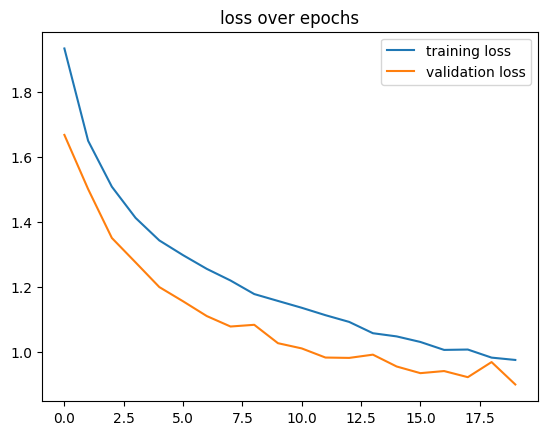

In [176]:
plt.plot(cnn_train_losses, label="training loss")
plt.plot(cnn_val_losses, label="validation loss")
plt.legend()
plt.title("loss over epochs")
plt.show()

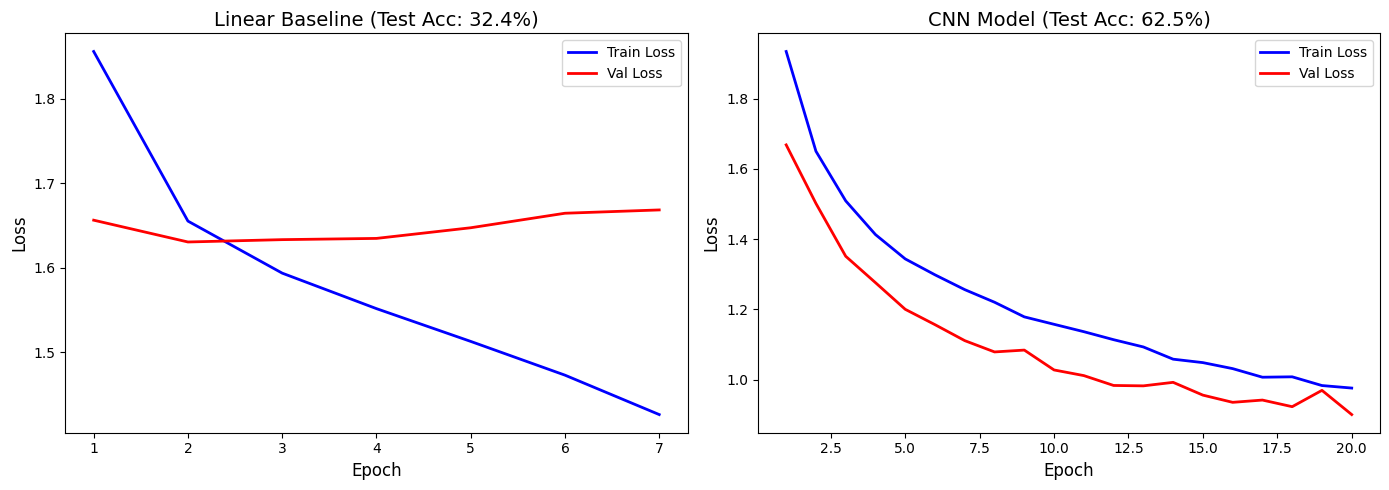

In [179]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Linear plot
epochs_linear = range(1, len(train_losses) + 1)
ax1.plot(epochs_linear, train_losses, 'b-', label='Train Loss', linewidth=2)
ax1.plot(epochs_linear, val_losses, 'r-', label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title(f'Linear Baseline (Test Acc: {test_acc:.1f}%)', fontsize=14)
ax1.legend()

# CNN plot
epochs_cnn = range(1, len(cnn_train_losses) + 1)
ax2.plot(epochs_cnn, cnn_train_losses, 'b-', label='Train Loss', linewidth=2)
ax2.plot(epochs_cnn, cnn_val_losses, 'r-', label='Val Loss', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_title(f'CNN Model (Test Acc: {cnn_test_acc:.1f}%)', fontsize=14)
ax2.legend()

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300)
plt.show()
